## **Import packages**

---



In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor, export_graphviz
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import Image
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.externals.six import StringIO
import io
import pydotplus
import warnings

warnings.filterwarnings('ignore')
# ! pip install graphviz pydotplus

## **Dataset loading**

---



In [ ]:
uploaded = files.upload()
train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
uploaded = files.upload()
test_df = pd.read_csv(io.BytesIO(uploaded['test.csv']))

## **Feature Engineering**

---



In [ ]:
train_df.shape, test_df.shape #getting the shape of the dataset

((10683, 11), (2671, 10))

In [ ]:
train_df.head() #showing first 5 data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
train_df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [ ]:
train_df.isnull().sum() #counting null values in each column

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [ ]:
train_df = train_df.dropna() #dropping null rows
train_df.shape

(10682, 11)

In [ ]:
#extracting features from data

train_df['Day'], train_df['Month'], train_df['Year'] = train_df['Date_of_Journey'].str.split('/', 3).str
train_df['Dep_Hr'], train_df['Dep_Min'] = train_df['Dep_Time'].str.split(':', 2).str

print(train_df['Arrival_Time'].unique())
#taking hours
train_df['Arrival_Time'], _ = train_df['Arrival_Time'].str.split(' ', 1).str
train_df['Arr_Hr'], train_df['Arr_Min'] = train_df['Arrival_Time'].str.split(':', 2).str
train_df['Duration'] = train_df['Duration'].str.replace('h ', ':').str.replace('m', '')
train_df['Duration_Hr'], train_df['Duration_Min'] = train_df['Duration'].str.split(':', 2).str
#taking unique stops
print(train_df['Total_Stops'].unique())

train_df['Total_Stops'], _ = train_df['Total_Stops'].str.split(' stops').str
train_df['Total_Stops'], _ = train_df['Total_Stops'].str.split(' stop').str
train_df['Total_Stops'] = train_df['Total_Stops'].apply(lambda x: 0 if 'non-stop' in x else x)

['01:10 22 Mar' '13:15' '04:25 10 Jun' ... '06:50 10 Mar' '00:05 19 Mar'
 '21:20 13 Mar']
['non-stop' '2 stops' '1 stop' '3 stops' '4 stops']


In [ ]:
train_cleaned_df = train_df.copy() #copying cleaned df
train_cleaned_df.drop(['Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration', 'Additional_Info'], axis = 1, inplace = True)
#showing new dataset shape
train_df.shape, train_cleaned_df.shape

((10682, 20), (10682, 15))

In [ ]:
train_cleaned_df.to_csv('train_cleaned.csv', index = False) # generating new csv dataset

## **Data Visualization**

---



In [ ]:
train_cleaned_df = pd.read_csv('train_cleaned.csv') #loading dataset
train_cleaned_df.head() #showing first 5 data

,Airline,Source,Destination,Route,Total_Stops,Price,Day,Month,Year,Dep_Hr,Dep_Min,Arr_Hr,Arr_Min,Duration_Hr,Duration_Min
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,3897,24,3,2019,22,20,1,10,2,50.0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,7662,1,5,2019,5,50,13,15,7,25.0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,13882,9,6,2019,9,25,4,25,19h,NaN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,6218,12,5,2019,18,5,23,30,5,25.0
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,13302,1,3,2019,16,50,21,35,4,45.0


In [ ]:
train_cleaned_df.describe()  #info about the dataset

,Total_Stops,Price,Day,Month,Year,Dep_Hr,Dep_Min,Arr_Hr,Arr_Min,Duration_Min
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.0,10682.000000,10682.000000,10682.000000,10682.000000,9650.00000
mean,0.824190,9087.214567,13.509081,4.708575,2019.0,12.491013,24.409287,13.349186,24.690601,31.35544
std,0.675229,4611.548810,8.479363,1.164408,0.0,5.748820,18.767801,6.859317,16.506808,14.93004
min,0.000000,1759.000000,1.000000,3.000000,2019.0,0.000000,0.000000,0.000000,0.000000,5.00000
25%,0.000000,5277.000000,6.000000,3.000000,2019.0,8.000000,5.000000,8.000000,10.000000,20.00000
50%,1.000000,8372.000000,12.000000,5.000000,2019.0,11.000000,25.000000,14.000000,25.000000,30.00000
75%,1.000000,12373.000000,21.000000,6.000000,2019.0,18.000000,40.000000,19.000000,35.000000,45.00000
max,4.000000,79512.000000,27.000000,6.000000,2019.0,23.000000,55.000000,23.000000,55.000000,55.00000


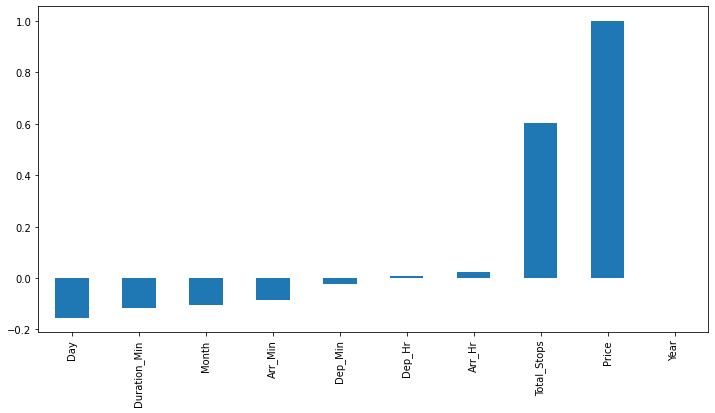

In [ ]:
#plotting corelation with the price
plt.figure(figsize = (12, 6))
train_cleaned_df.corr()['Price'].sort_values().plot(kind = 'bar')

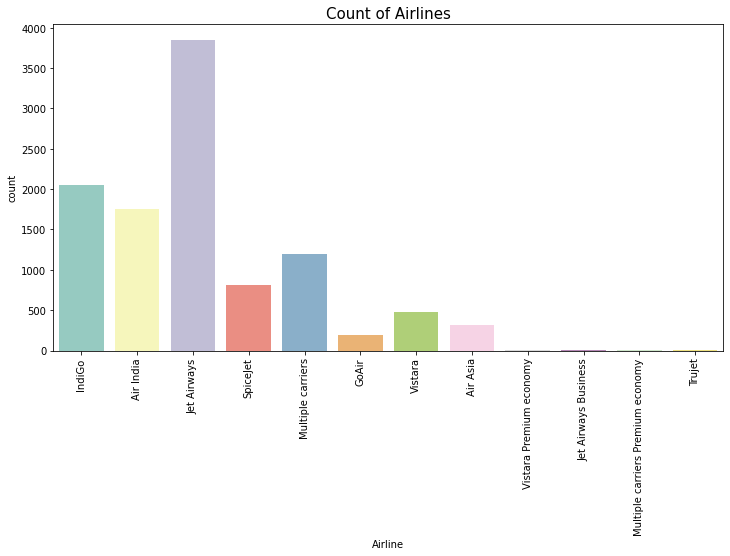

In [ ]:
#Plotting airlines with count
plt.figure(figsize = (12, 6))
sns.countplot(train_cleaned_df['Airline'], palette = 'Set3')
plt.title('Count of Airlines', size = 15)
plt.xticks(rotation = 90)
plt.show()

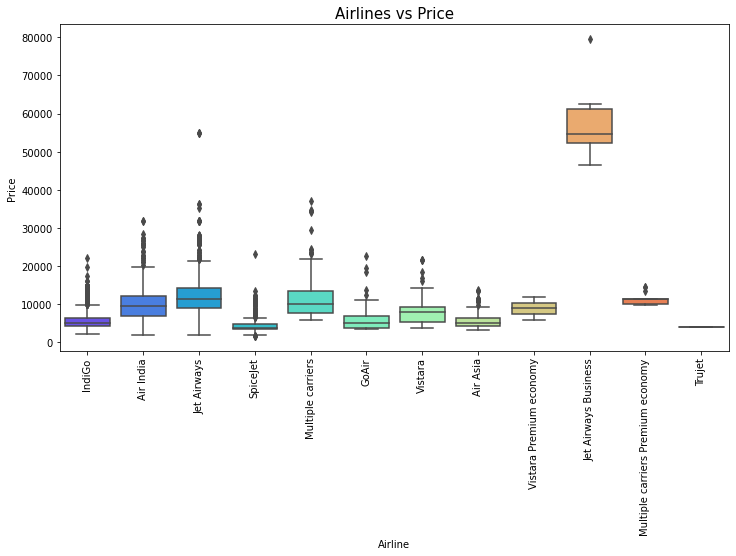

In [ ]:
#Airlines vs Price 
plt.figure(figsize = (12,6))
sns.boxplot(x='Airline', y='Price', data=train_cleaned_df, palette='rainbow')
plt.title('Airlines vs Price', size = 15)
plt.xticks(rotation = 90)
plt.show()

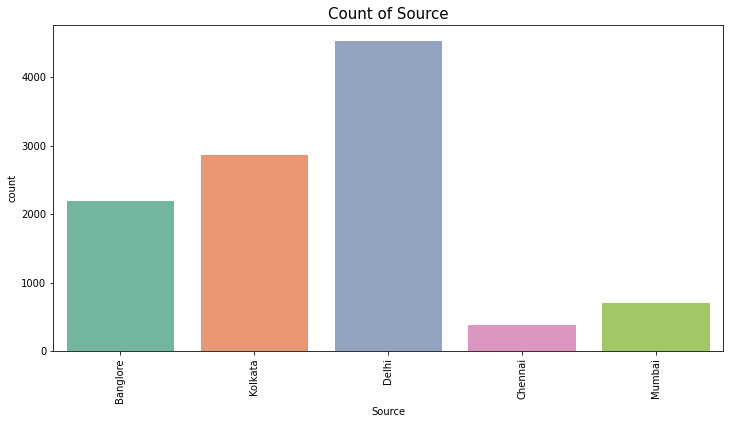

In [ ]:
#Count of Source plotting
plt.figure(figsize = (12, 6))
sns.countplot(train_cleaned_df['Source'], palette = 'Set2')
plt.title('Count of Source', size = 15)
plt.xticks(rotation = 90)
plt.show()

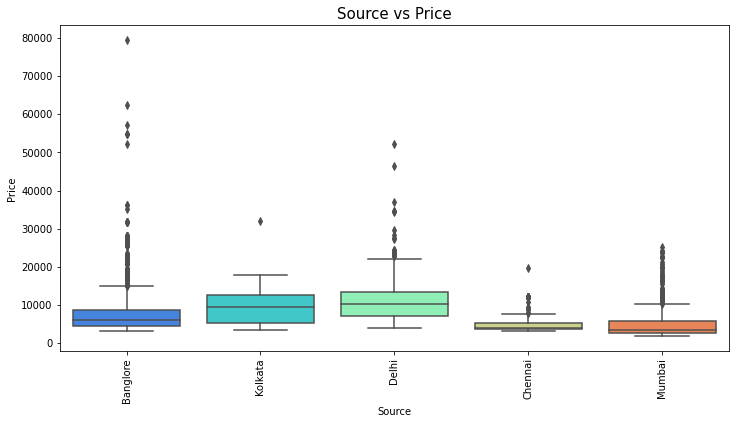

In [ ]:
#source vs price plotting
plt.figure(figsize = (12, 6))
sns.boxplot(x='Source', y='Price', data=train_cleaned_df, palette='rainbow')
plt.title('Source vs Price', size = 15)
plt.xticks(rotation = 90)
plt.show()

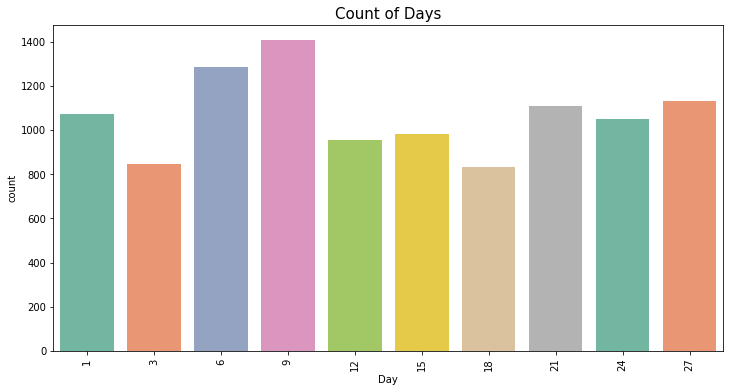

In [ ]:
#days counting
plt.figure(figsize = (12, 6))
sns.countplot(train_cleaned_df['Day'], palette = 'Set2')
plt.title('Count of Days', size = 15)
plt.xticks(rotation = 90)
plt.show()

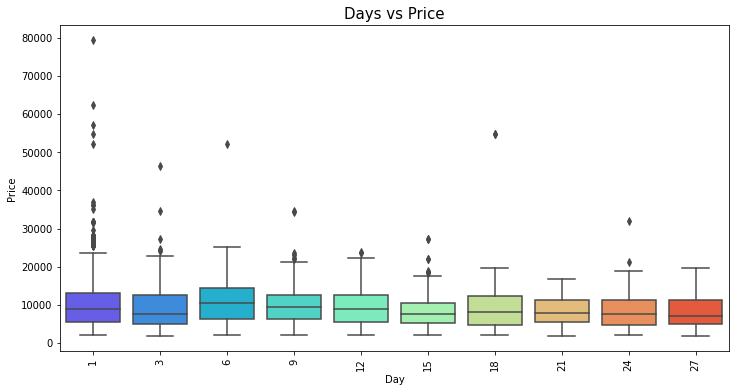

In [ ]:
#price vs day plotting
plt.figure(figsize = (12, 6))
sns.boxplot(x='Day', y='Price', data=train_cleaned_df, palette='rainbow')
plt.title('Days vs Price', size = 15)
plt.xticks(rotation = 90)
plt.show()

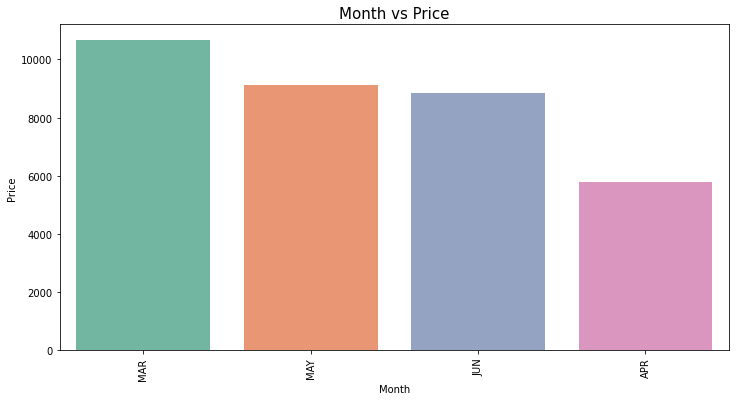

In [ ]:
train_cleaned_df['Month'] = train_cleaned_df['Month'].map({
    1:'JAN',
    2:'FEB',
    3:'MAR',
    4:'APR',
    5:'MAY',
    6:'JUN',
    7:'JUL',
    8:'AUG',
    9:'SEP',
    10:'OCT',
    11:'NOV',
    12:'DEC'
})

plt.figure(figsize = (12, 6))
sns.barplot(train_cleaned_df['Month'], train_cleaned_df['Price'], palette = 'Set2', ci = None)
plt.title('Month vs Price', size = 15)
plt.xticks(rotation = 90)
plt.show()

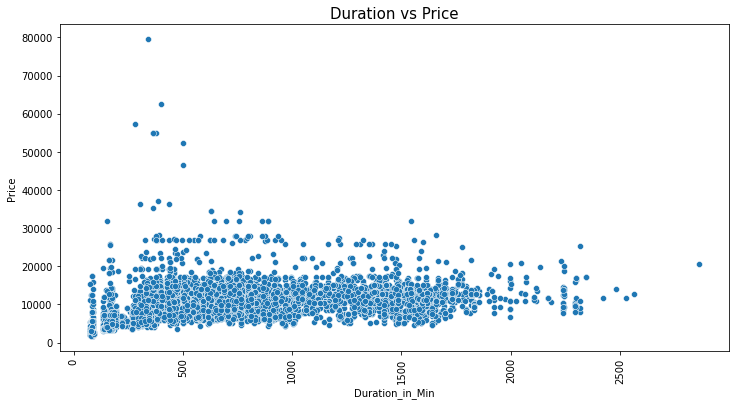

In [ ]:
train_cleaned_df['Duration_Hr'], _ = train_cleaned_df['Duration_Hr'].str.split('h', 1).str
train_cleaned_df['Duration_Hr'] = train_cleaned_df['Duration_Hr'].astype(int)
train_cleaned_df['Duration_in_Min'] = (train_cleaned_df['Duration_Hr'] * 60) + train_cleaned_df['Duration_Min']

plt.figure(figsize = (12, 6))
sns.scatterplot(train_cleaned_df['Duration_in_Min'], train_cleaned_df['Price'], palette = 'Set2')
plt.title('Duration vs Price', size = 15)
plt.xticks(rotation = 90)
plt.show()

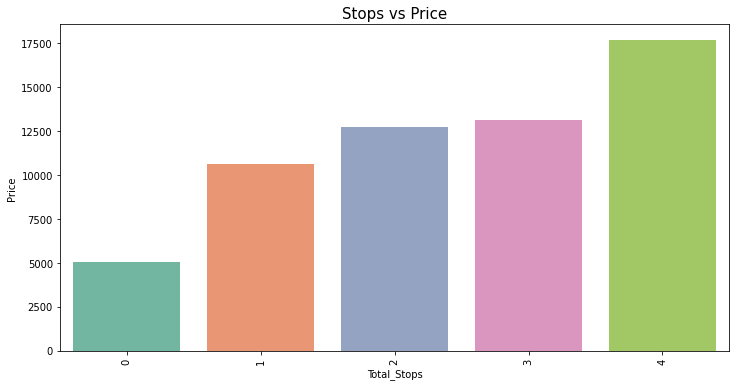

In [ ]:
plt.figure(figsize = (12, 6))
sns.barplot(train_cleaned_df['Total_Stops'], train_cleaned_df['Price'], palette = 'Set2', ci = None)
plt.title('Stops vs Price', size = 15)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
train_cleaned_df = train_cleaned_df.dropna()

In [ ]:
train_cleaned_df.to_csv('train_final.csv', index = None)

## **Trained Models**

---



### **Train-Test Preperation**

In [ ]:
train_final_df = pd.read_csv('train_final.csv')
train_final_df.shape

(9650, 16)

In [ ]:
train_final_df.head()

,Airline,Source,Destination,Route,Total_Stops,Price,Day,Month,Year,Dep_Hr,Dep_Min,Arr_Hr,Arr_Min,Duration_Hr,Duration_Min,Duration_in_Min
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,3897,24,MAR,2019,22,20,1,10,2,50.0,170.0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,7662,1,MAY,2019,5,50,13,15,7,25.0,445.0
2,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,6218,12,MAY,2019,18,5,23,30,5,25.0,325.0
3,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,13302,1,MAR,2019,16,50,21,35,4,45.0,285.0
4,SpiceJet,Kolkata,Banglore,CCU → BLR,0,3873,24,JUN,2019,9,0,11,25,2,25.0,145.0


In [ ]:
df = train_final_df[['Airline', 'Source', 'Destination', 'Total_Stops', 'Price', 'Day', 'Month', 'Duration_in_Min']]
df = df.rename(columns = {'Duration_in_Min' : 'Duration'})
df.shape

(9650, 8)

In [ ]:
df.isnull().any().any()

False

In [ ]:
df['Month'] = df['Month'].map({
    'JAN':1,
    'FEB':2,
    'MAR':3,
    'APR':4,
    'MAY':5,
    'JUN':6,
    'JUL':7,
    'AUG':8,
    'SEP':9,
    'OCT':10,
    'NOV':11,
    'DEC':12
})

dummies = pd.get_dummies(df[['Airline', 'Source', 'Destination']])
df = pd.concat([df, dummies], axis = 1)
df = df.drop(['Airline', 'Source', 'Destination'], axis = 1)
df.shape

(9650, 28)

In [ ]:
df.head()

,Total_Stops,Price,Day,Month,Duration,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,170.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,445.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,1,6218,12,5,325.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,1,13302,1,3,285.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,3873,24,6,145.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [ ]:
X = df.drop('Price', axis = 1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 60)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6755, 27), (2895, 27), (6755,), (2895,))

### **Linear Regression**

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Total_Stops,2826.142915
Day,-80.017924
Month,-464.527847
Duration,-0.072202
Airline_Air Asia,-4940.494021
Airline_Air India,-3404.942756
Airline_GoAir,-4832.434951
Airline_IndiGo,-4749.377577
Airline_Jet Airways,-513.390594
Airline_Jet Airways Business,38420.358683


In [ ]:
y_pred = regressor.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df

,Actual,Predicted
2395,3898,4802.569871
1977,8032,11189.142450
9107,5192,10258.056747
9597,4340,6311.735906
9050,10844,11113.946199
...,...,...
4007,4049,1795.707404
9148,5989,5271.185064
3925,15135,12556.615768
7692,12681,12957.551314


In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1926.5518151166166
Mean Squared Error: 7906187.845686001
Root Mean Squared Error: 2811.794417393633


### **Ridge Regression**

In [ ]:
clf = Ridge()
clf.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
y_pred = clf.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df

,Actual,Predicted
2395,3898,4836.045923
1977,8032,11194.386525
9107,5192,10307.303725
9597,4340,6348.885305
9050,10844,11105.759442
...,...,...
4007,4049,1779.363606
9148,5989,5292.250413
3925,15135,12573.985533
7692,12681,12968.090615


In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1931.7119315555547
Mean Squared Error: 8067530.230997833
Root Mean Squared Error: 2840.3398090717656


### **Lasso Regression**

In [ ]:
clf = Lasso()
clf.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df

,Actual,Predicted
2395,3898,4858.980225
1977,8032,11192.460746
9107,5192,10289.928453
9597,4340,6354.685300
9050,10844,11110.248253
...,...,...
4007,4049,1801.906728
9148,5989,5302.862512
3925,15135,12551.271805
7692,12681,12956.075178


In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1926.6401218436465
Mean Squared Error: 7935850.179023421
Root Mean Squared Error: 2817.0641063034795


### **Elastic Net**

In [ ]:
clf = ElasticNet()
clf.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df

,Actual,Predicted
2395,3898,7206.661259
1977,8032,12351.342433
9107,5192,9499.451871
9597,4340,6646.298511
9050,10844,9716.369125
...,...,...
4007,4049,4060.323598
9148,5989,7189.288960
3925,15135,10706.550164
7692,12681,10845.838942


In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2368.0422344828094
Mean Squared Error: 11898204.489867266
Root Mean Squared Error: 3449.3774061223376


### **Decision Tree Regression**

In [ ]:
clf = DecisionTreeRegressor(random_state = 0) 
clf.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
y_pred = clf.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df

,Actual,Predicted
2395,3898,3898.000000
1977,8032,6850.000000
9107,5192,7870.000000
9597,4340,4722.750000
9050,10844,14781.000000
...,...,...
4007,4049,3010.000000
9148,5989,4409.000000
3925,15135,18916.000000
7692,12681,9303.666667


In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1489.4788107574636
Mean Squared Error: 6535690.766281593
Root Mean Squared Error: 2556.499709814494


In [ ]:
feature_cols =['Total_Stops', 'Price', 'Day', 'Month', 'Duration', 'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir',
               'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers',
               'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara',
               'Airline_Vistara Premium economy', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
               'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
               'Destination_Kolkata', 'Destination_New Delhi']

### **Random Forest Regression**

In [ ]:
clf = RandomForestRegressor() 
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df

,Actual,Predicted
2395,3898,4126.200000
1977,8032,6553.380000
9107,5192,7348.340000
9597,4340,4780.465446
9050,10844,13831.799333
...,...,...
4007,4049,3135.113844
9148,5989,4609.120000
3925,15135,17879.447929
7692,12681,9464.864345


In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1335.2773812860562
Mean Squared Error: 5113215.237076077
Root Mean Squared Error: 2261.2419678300853


### **Gradient Boosting Regression**

In [ ]:
clf = GradientBoostingRegressor() 
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df

,Actual,Predicted
2395,3898,4473.062081
1977,8032,8368.794642
9107,5192,8446.642267
9597,4340,5311.754907
9050,10844,11675.810819
...,...,...
4007,4049,3113.849820
9148,5989,4433.108655
3925,15135,14988.540355
7692,12681,11510.562778


In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1505.3244473716152
Mean Squared Error: 5142350.341134013
Root Mean Squared Error: 2267.6750960254453
